In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
    
from tensorpack import TowerContext, logger
from tensorpack.tfutils import varmanip, get_model_loader
from tensorpack.graph_builder.input_source import PlaceholderInput
%matplotlib inline

In [2]:
ternary_log = 'train_log/sentfilt25_cnn_twnTrue_preload/ternary_weights.npz'
reg_meta = 'train_log/sentfilt25_cnn_twnFalse/graph-1021-015614.meta'
reg_model = 'train_log/sentfilt25_cnn_twnFalse/min-val-error-top1'

In [3]:
data = dict(np.load(ternary_log).items())
conv_data = data['InferenceTower/conv0/ternarized_W']

uniqs = np.unique(conv_data)
assert len(uniqs) == 3
wn,wp = uniqs[0], uniqs[2]
print('wp',wp,'wn', wn, 'z', uniqs[1])

norm_conv_data = np.where(conv_data < 0, -1, conv_data)
norm_conv_data = np.where(conv_data > 0, 1, norm_conv_data)
pic_data = (norm_conv_data[:,:,0,:] + 1.0)/2
norm_conv_data = norm_conv_data.astype(int)

uniqs = np.unique(norm_conv_data)
assert len(uniqs) == 3
wn,wp = uniqs[0], uniqs[2]
print('wp',wp,'wn',wn, 'z', uniqs[1])

('wp', 3.077368e-19, 'wn', -3.077368e-19, 'z', -0.0)
('wp', 1, 'wn', -1, 'z', 0)


In [4]:
# frequency counts
tmp = np.where(norm_conv_data < 0, 2, norm_conv_data) # make -1 as 2
y = np.bincount(tmp.flatten())
ii = np.nonzero(y)[0]
zip(ii,y[ii])

[(0, 193), (1, 1053), (2, 1058)]

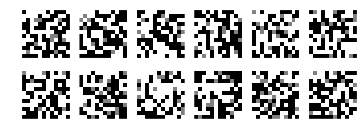

In [5]:
num_cols = 6
num_rows = 2
plt.clf()
plt.figure(figsize = (num_cols, num_rows))
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.2, hspace=0.2) # set the spacing between axes.
for x in range(num_rows):
    for y in range(num_cols):
        idx = x*num_cols + y
        plt.subplot(gs[idx])
        plt.imshow(pic_data[:,:,idx], cmap='gray', interpolation='none')
        #plt.title("Conv0_%d" % (idx,))
        plt.axis('off')
plt.show()

In [6]:
with tf.Graph().as_default() as G:
    tf.train.import_meta_graph(reg_meta)
    init = get_model_loader(reg_model)
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    sess.run(tf.global_variables_initializer())
    init.init(sess)

    with sess.as_default():
        varmanip.dump_session_params('/tmp/params.npz')

data = dict(np.load('/tmp/params.npz').items())
conv_data = data['conv0/W:0'][:,:,0,:]

[1025 21:44:52 @sessinit.py:119] Restoring checkpoint from train_log/sentfilt25_cnn_twnFalse/min-val-error-top1 ...
INFO:tensorflow:Restoring parameters from train_log/sentfilt25_cnn_twnFalse/min-val-error-top1
[1025 21:44:53 @varmanip.py:128] Variables to save to /tmp/params.npz:
[1025 21:44:53 @varmanip.py:130] [u'conv0/W:0',
 u'conv0/bn/beta:0',
 u'conv0/bn/gamma:0',
 u'conv0/bn/mean/EMA:0',
 u'conv0/bn/variance/EMA:0',
 u'last_linear/W:0',
 u'last_linear/b:0',
 u'linear0/W:0',
 u'linear0/b:0',
 u'linear0/bn/beta:0',
 u'linear0/bn/gamma:0',
 u'linear0/bn/mean/EMA:0',
 u'linear0/bn/variance/EMA:0',
 u'linear1/W:0',
 u'linear1/b:0',
 u'linear1/bn/beta:0',
 u'linear1/bn/gamma:0',
 u'linear1/bn/mean/EMA:0',
 u'linear1/bn/variance/EMA:0',
 u'linear2/W:0',
 u'linear2/b:0',
 u'linear2/bn/beta:0',
 u'linear2/bn/gamma:0',
 u'linear2/bn/mean/EMA:0',
 u'linear2/bn/variance/EMA:0']


In [7]:
mi = np.min(conv_data)
ma = np.max(conv_data)
rang = ma - mi
reg_norm_conv_data = (conv_data - mi)/rang

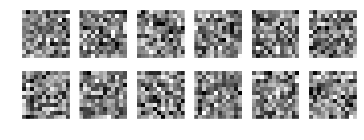

In [8]:
num_cols = 6
num_rows = 2
plt.clf()
plt.figure(figsize = (num_cols, num_rows))
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.2, hspace=0.2) # set the spacing between axes.
for x in range(num_rows):
    for y in range(num_cols):
        idx = x*num_cols + y
        plt.subplot(gs[idx])
        plt.imshow(reg_norm_conv_data[:,:,idx], cmap='gray', interpolation='none')
        #plt.title("Conv0_%d" % (idx,))
        plt.axis('off')
plt.show()

In [9]:
tern_conv_data = np.ones(conv_data.shape)

for i in range(16):
    curr_filt = conv_data[:,:,i]
    thre_x = np.max(np.abs(curr_filt))*0.05
    shape = curr_filt.shape
    mask = np.ones(shape)
    mask_p = np.where(curr_filt > thre_x, np.ones(shape) * 1, mask)
    mask_np = np.where(curr_filt < -thre_x, np.ones(shape) * 1, mask_p)
    mask_z = np.where((curr_filt < thre_x) & (curr_filt > - thre_x), np.zeros(shape), mask)
    tern_curr_filt =  np.sign(curr_filt) * mask_z
    tern_curr_filt = tern_curr_filt * mask_np
    tern_curr_filt = (tern_curr_filt + 1.0)/2
    tern_conv_data[:,:,i] = tern_curr_filt
# 

In [157]:
# conv_data[:,:,0], thre_x
tern_curr_filt

array([[ 1. ,  0. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  0. ,  0. ,  1. ,
         0. ],
       [ 1. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0.5,  1. ,  0.5,  0. ,  0. ,
         0. ],
       [ 0. ,  0.5,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  0. ,  0.5,  1. ,
         0. ],
       [ 1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,  0. ,  0. ,  0. ,  1. ,
         1. ],
       [ 1. ,  0. ,  0. ,  0. ,  1. ,  0.5,  0. ,  0.5,  1. ,  1. ,  0. ,
         0. ],
       [ 1. ,  0.5,  1. ,  1. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0.5,  1. ,
         0. ],
       [ 0. ,  1. ,  1. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  0. ,  0. ,
         1. ],
       [ 0. ,  1. ,  0. ,  1. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  1. ,
         0. ],
       [ 0. ,  1. ,  1. ,  0.5,  1. ,  1. ,  0.5,  1. ,  1. ,  0. ,  0. ,
         0. ],
       [ 0. ,  0. ,  1. ,  0.5,  1. ,  0. ,  0. ,  0. ,  1. ,  0. ,  1. ,
         1. ],
       [ 0. ,  1. ,  0. ,  0. ,  1. ,  0. ,  1. ,  1. ,  1. ,  1. ,  1. ,
         0. ],
       [ 1. ,  0.5,  

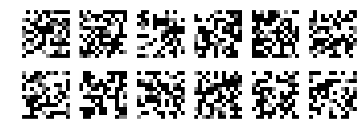

In [10]:
num_cols = 6
num_rows = 2
plt.clf()
plt.figure(figsize = (num_cols, num_rows))
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.2, hspace=0.2) # set the spacing between axes.
for x in range(num_rows):
    for y in range(num_cols):
        idx = x*num_cols + y
        plt.subplot(gs[idx])
        plt.imshow(tern_conv_data[:,:,idx], cmap='gray', interpolation='none')
        #plt.title("Conv0_%d" % (idx,))
        plt.axis('off')
plt.show()

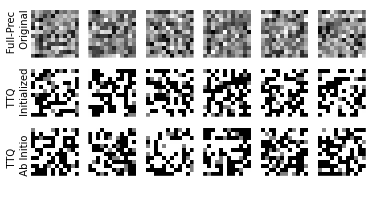

In [32]:
plt.clf()
num_cols = 6
num_rows = 3
fig = plt.figure(figsize = (num_cols, num_rows))
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.2, hspace=0.2) # set the spacing between axes.
for x in range(num_rows):
    for y in range(num_cols):
        idx = x*num_cols + y
        plt.subplot(gs[idx])
        if x == 0:
            dat = reg_norm_conv_data
        elif x == 1:
            dat = tern_conv_data
        elif x == 2:
            dat = pic_data
        plt.imshow(dat[:,:,num_cols + y], cmap='gray', interpolation='none')
        plt.axis('off')
fig.text(0.1, 0.5, '  Ab Initio      Initialized      Original', va='center', rotation='vertical')
fig.text(0.07, 0.5, '    TTQ             TTQ           Full-Prec', va='center', rotation='vertical')
plt.show()

In [37]:
np.count_nonzero(tern_conv_data)/(0.0 + np.prod(tern_conv_data.shape))

0.55078125

In [38]:
np.count_nonzero(pic_data)/(0.0 + np.prod(tern_conv_data.shape))

0.5407986111111112